# Introduction

This notebook provides sample code for analyzing financial data with Granger
Causality, ACF, and PACF. If you encounter bugs then try using Python 3.8.5.
If you still encounter bugs then let me know.

In this notebook I include a function to grab the last 5000 candles of pricing data from Oanda's API,
then dump it into a spreadsheet. I cannot include the data because their terms of service does not
allow it. If you want to use the function then you will need an Oanda demo or live account.

If you want to use your own data source then that's fine too. More details are in the function
descriptions below.

More detail on ACF and PACF can be found here:
- https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8

More detail on Granger's Causality can be found here:
- https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6

Finally, if people find this helpful then I can add some other useful statistical and machine learning functions.

Just let me know.

# Setup

## Setup: Imports

In [1]:
import getpass
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Setup: Functions

In [2]:
def create_df(csv_file, instrument):
    '''
    Creates a dataframe from a CSV file. 

    NOTE: If you use my function to pull pricing data from Oanda (see below) then you
          do not need this function. This is only included so that you can load your
          own data.

    NOTE: There must be a column named 'date' in the CSV file, and it needs to contain
          the candle timestamp in a format that Pandas can read. If you use Oanda's data
          (see the next function) then it's not a problem. Pandas can convert their format.
          If you use a different data source then you might have to format the date in
          the CSV file before reading it into Pandas

    Args:
        csv_file (str):     The name of the CSV file
        instrument (str):   The name of the instrument (EUR_USD, USD_CAD, etc)

    Returns:
        df (DataFrame):     A Pandas dataframe containing the CSV file data
    '''

    # Create {df} as an empty dataframe then delete it. I use this throughout
    # this notebook. I have been burnt many times by Jupyter corrupting dataframes
    # when I try to re-use the same dataframe variable name
    df = pd.DataFrame(list(), columns=list())
    del df
    # Import the CSV file to a dataframe
    df = pd.read_csv(csv_file)
    # Convert the date column to datetime
    df['date'] = pd.to_datetime(df['date'])
    # Set the date column as the index
    df = df.set_index('date')
    # Add the instrument names to cols
    cols = [f'{instrument.lower()}_{c}' for c in df.columns.tolist()]
    df.columns = cols
    # Remove any NaN rows
    df = df.dropna()
    # Convert numeric values in the dataframe to the correct type
    df = df.apply(pd.to_numeric, errors='ignore')
    return df


def get_oanda_price_data(account,
                         api_key,
                         endpoint,
                         granularity,
                         instruments,
                         price_type,
                         count='5000'):
    '''
    This function creates dataframes for each instrument and granularity by querying
    the Oanda API. It gets the most recent 5000 candles.

    You do not have to use this function. If you have your own data, then this notebook
    contains another function that will import it from a CSV file and convert it to a
    dataframe
    
    I include this as an easy starting point. If you want more than 5000 candles, you can check
    out their API documentation. It explains how to request candle pricing data for
    specific date ranges. The maximum is still 5000 records, but you can run it in a
    loop to get as much historical data as you want.

    Args:
        account (str):          The Oanda account number
        api_key (str):          The Oanda API key created from within the demo or live account
        endpoint (str):         The endpoint to use ('fxtrade' for live, 'fxpractice' for demo)
        granularity (str):      The granularity (timeframe) to query. The API documentation contains
                                a full list. Commonly used granularities are S5, M1, M2, M5, M10,
                                M15, M30, H1, H4, D, W, M
        instruments (list):     A list containing the currency pairs, in the format of 'EUR_USD',
                                'USD_CAD', 'GBP_USD', etc
        price_type (str):       The type of pricing to retrieve. Valid values are 'ask', 'bid', 'mid'
        count (str):            The number of candles to return. Max is 5000
    
    Returns:
        df_dict (dict):         A dictionary containing the instruments, granularities, and dataframes
    '''
    df_dict = dict()
    for i in instruments:
        # Construct the URL
        count = str(count)
        p_type = price_type[0].upper()
        header = {'Authorization': f'Bearer {api_key}'}
        url = [f'https://api-{endpoint}.oanda.com/v3/accounts/{account}',
               f'instruments/{i}',
               f'candles?price={p_type}&count={count}&granularity={granularity}']
        url = '/'.join(url)
        # Execute the request
        response = requests.get(url, headers=header)
        # Extract the price data and dump it to a nested list
        candle_data = list()
        content = json.loads(response.content)
        candle_dict = content['candles']
        for item in candle_dict:
            # Get the close timestamp of the candle
            ts = item['time']
            # Get the volume of the candle
            volume = item['volume']
            # Get the OHLC for the candle
            o = item[price_type]['o']
            h = item[price_type]['h']
            l = item[price_type]['l']
            c = item[price_type]['c']
            # Add the extracted variables to candle_data
            candle_data.append([ts, o, h, l, c, volume])
        # Create an empty dataframe then delete it to avoid data corruption
        df = pd.DataFrame(list(), columns=list())
        del df
        # Recreate the dataframe and populate it with the API data
        cols = ['date', 'open', 'high', 'low', 'close', 'volume']
        df = pd.DataFrame(candle_data, columns=cols)
        # Convert the date column to datetime
        df['date'] = pd.to_datetime(df['date'])
        # Set the date column as the index
        df = df.set_index('date')
        # Remove the NaN rows
        df = df.dropna()
        # Convert numeric values in the dataframe to the correct type
        df = df.apply(pd.to_numeric, errors='ignore')
        # Add the dataframe to df_dict
        df_dict[i] = df
    # Return the data
    return df_dict


def join_dfs(df_dict):
    '''
    Merges dataframes by their index (the date). The column names are converted to
    include the instrument

    NOTE: If you use my function to pull the data from the Oanda API, then the dataframes
          are already loaded into df_dict. If you are using your own data, then you will
          need to create the dataframes using the 'create_df' function, then manually
          create df_dict before passing it to this function

          The format of df_dict should look like this, where each key is the currency pair
          name and each value is the dataframe for that currency pair:

          df_dict = {'EUR_USD': df_eur_usd,
                     'USD_CAD': df_usd_cad,
                     'GBP_USD': df_gbp_usd}
        
         I provide example code for further down in the notebook

    Args:
        df_dict (dict): A dictionary containing the dataframes to merge. The format
                        that each key is an instrument (like 'EUR_USD') and each value
                        is the dataframe for that instrument

    Returns:
        df (DataFrame): The joined dataframes
        df_dict (dict): The df_dict with updated column names for each dataframe
    '''
    # Rename the columns for each of the dataframes in df_dict
    for key, value in df_dict.items():
        df = pd.DataFrame(list(), columns=list())
        del df
        # Rename the columns for each dataframe in df_dict
        df = df_dict[key]
        cols = df.columns.tolist()
        instrument = key
        cols = [f'{instrument.lower()}_{c}' for c in cols]
        df.columns = cols
        df_dict[key] = df
    # Merge the dataframes, using the first instrument in df_dict
    # as the base dataframe
    df = pd.DataFrame(list(), columns=list())
    del df
    instruments = list(df_dict.keys())
    df = df_dict[instruments[0]]
    for i in instruments[1:]:
        df = df.join(df_dict[i], how='outer')
    # Return the data
    return df, df_dict


def calculate_p_values(cols, df):
    '''
    Tests the stationarity of a dataframe by calculating the p-value.

    Args:
        cols (list):    The columns to calculate the p-value on.
        df (dataframe): The dataframe to test stationarity on.

    Returns:
        p_vals (dict):  A dictionary containing the p-value for each
                        column. The key is the column and the value
                        is the p-value rounded to 2 decimal places.
    '''
    p_vals = dict()
    for col in cols:
        adf = adfuller(df[col], autolag='AIC')
        p = round(adf[1], 2)
        p_vals[col] = p
    return p_vals


def df_make_stationary(df_joined, sig=0.05):
    '''
    Makes a time series stationary, using the adfuller test. If the
    p-value is less than 0.05 then the series is considered stationary.

    Args:
        df_joined (dataframe):      The dataframe to make stationary
        sig (float):                The p-value threshold.

    Returns:
        df_stationary (dataframe):  The stationary dataframe.
        num_diffs (int):            The number of diffs required to make series
                                    stationary.
    '''
    df_stationary = df_joined.copy()
    num_diffs = 0  # This counter will be incremented each time the dataframe is diffed
    # Find out if the series is already stationary (it almost certainly is not)
    col_names = df_stationary.columns.tolist()
    p_vals = calculate_p_values(col_names, df_stationary)
    stationary = test_stationarity(p_vals, sig)
    # Make the columns stationary, if they aren't already
    while not stationary:
        for col in col_names:
            df_stationary[col] = df_stationary[col].diff()
        df_stationary = df_stationary.dropna()
        num_diffs += 1
        p_vals = calculate_p_values(col_names, df_stationary)
        stationary = test_stationarity(p_vals, sig)
    # Return the data
    return df_stationary, num_diffs


def test_stationarity(p_vals, sig):
    '''
    Tests if the specified columns in a dataframe are stationary. Uses
    the adfuller test.

    Args:
        p_vals (dict):  A dictionary containing columns names and p_values.
        sig (float):    The p-value threshold.

    Returns:
        stationary (bool):  Whether or not the columns are stationary.
    '''
    stationary = True
    for key, value in p_vals.items():
        if value > sig:
            stationary = False
            break
    return stationary

## Setup: Load pricing data into dataframes

### Method 1: Get the data from the Oanda API (easiest)

(Comment out this cell if you use your own data (Method 2))

In [3]:
account = getpass.getpass('enter the account number')
api_key = getpass.getpass('enter the api key')

endpoint = 'fxpractice'  # For demo accounts
# endpoint = 'fxtrade'  # For live accounts
granularity = 'H1'
instruments = ['EUR_USD', 'USD_CAD']
price_type = 'mid'
count = '5000'

df_dict = get_oanda_price_data(account,
                               api_key,
                               endpoint,
                               granularity,
                               instruments,
                               price_type,
                               count)

# Merge the dataframes
df_joined, df_dict = join_dfs(df_dict)

del account
del api_key

## Method 2: Load your own data

(The code below is commented out; uncomment it and comment out the previous cell if you use your own data)

In [4]:
# NOTE: You will need to use your own CSV files

# # Create a dataframe for each instrument that you want to evaluate
# csv_file = 'sample_eur_usd.csv'
# df_eur_usd = create_df(csv_file, 'EUR_USD')

# csv_file = 'sample_usd_cad.csv'
# df_gbp_usd = create_df(csv_file, 'USD_CAD')

# # Add the CSV files to df_dict
# df_dict = dict()
# df_dict['EUR_USD'] = df_eur_usd
# df_dict['USD_CAD'] = df_gbp_usd

# # Merge the dataframes
# df_joined, df_dict = join_dfs(df_dict)

## Setup: Make the dataframe stationary

In [5]:
cols = df_joined.columns.tolist()

df_stationary, num_diffs = df_make_stationary(df_joined)

# Add _diff to the column names (not necessary, but helps keep track of what's what)
cols = [f'{c}_diff' for c in cols]

df_stationary.columns=cols

## Setup: Visualize the stationary dataframe to make sure nothing is glaringly wrong

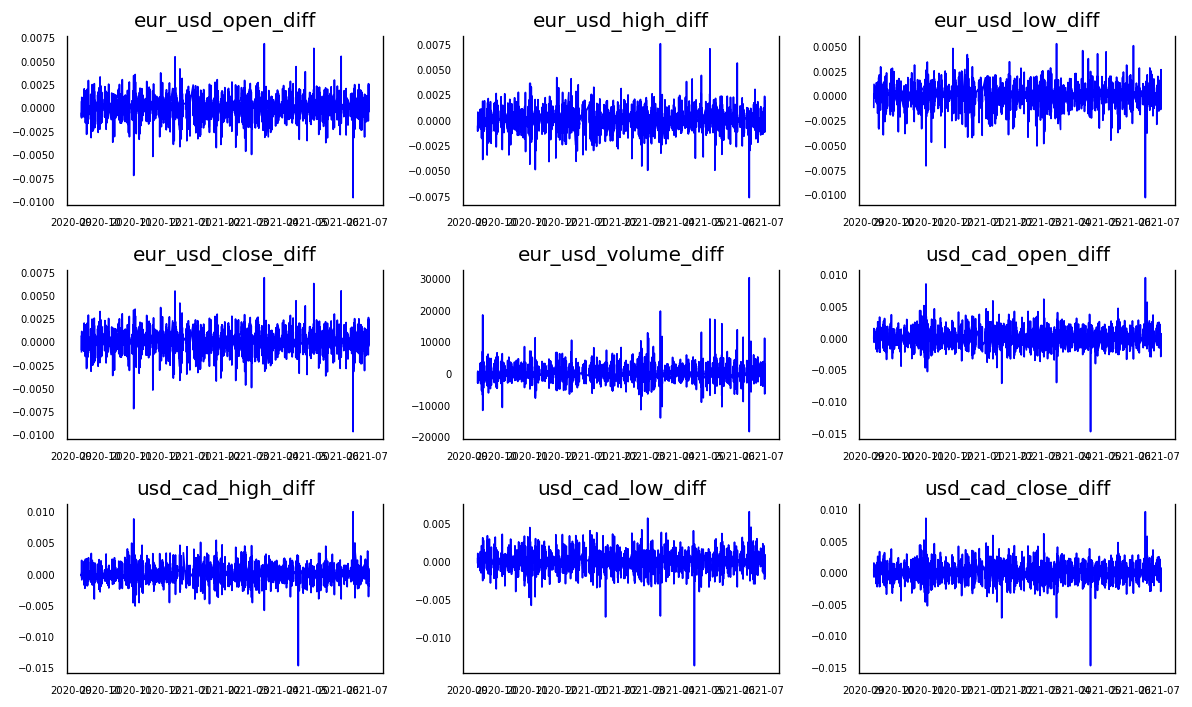

In [6]:
# Visualize the stationary data
fig, axes = plt.subplots(nrows=3, ncols=3, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df_stationary[df_stationary.columns[i]]
    ax.plot(data, color='blue', linewidth=1)
    # Decorations
    ax.set_title(df_stationary.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout()

# Implementation: Run Granger's Causality and visualize the results as a matrix

In [7]:
maxlag=25
test = 'ssr_chi2test'

def grangers_causation_matrix(df_stationary, variables, test='ssr_chi2test', verbose=False):
    '''
    Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    NOTE: Shout out to Sarit Maitra from TowardsDataScience.com for this code, as well
    as the function description. He in turn credits Stack Overflow

    - https://towardsdatascience.com/granger-causality-and-vector-auto-regressive-model-for-time-series-forecasting-3226a64889a6
    - https://stackoverflow.com/questions/58005681/is-it-possible-to-run-a-vector-autoregression-analysis-on-a-large-gdp-data-with

    Args:
        df_stationary (DataFrame):      A dataframe containing the stationary time series data
        variables (list):               The dataframe column names

    Returns:
        df_grangers (DataFrame):    A dataframe containing the causality matrix
    '''
    df_grangers = pd.DataFrame(list(), columns=list())
    df_grangers = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df_grangers.columns:
        for r in df_grangers.index:
            test_result = grangercausalitytests(df_stationary[[r, c]],
                                                maxlag=maxlag,
                                                verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose:
                print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df_grangers.loc[r, c] = min_p_value
    df_grangers.columns = [var + '_x' for var in variables]
    df_grangers.index = [var + '_y' for var in variables]
    return df_grangers

df_grangers = grangers_causation_matrix(df_stationary, variables=df_stationary.columns)

In [8]:
df_grangers.head(20)

eur_usd_open_diff_x  eur_usd_high_diff_x  \
eur_usd_open_diff_y                 1.0000               0.0000   
eur_usd_high_diff_y                 0.0000               1.0000   
eur_usd_low_diff_y                  0.0000               0.0000   
eur_usd_close_diff_y                0.0000               0.0897   
eur_usd_volume_diff_y               0.0003               0.0000   
usd_cad_open_diff_y                 0.0641               0.0000   
usd_cad_high_diff_y                 0.0010               0.0000   
usd_cad_low_diff_y                  0.0010               0.0000   
usd_cad_close_diff_y                0.0100               0.1270   
usd_cad_volume_diff_y               0.0028               0.0000   

                       eur_usd_low_diff_x  eur_usd_close_diff_x  \
eur_usd_open_diff_y                0.0000                0.0000   
eur_usd_high_diff_y                0.0000                0.0000   
eur_usd_low_diff_y                 1.0000                0.0000   
eur_usd_close_diff_y               0.0001                1.0000   
eur_usd_volume_diff_y              0.0000                0.0000   
usd_cad_open_diff_y                0.0000                0.0000   
usd_cad_high_diff_y                0.0010                0.0000   
usd_cad_low_diff_y                 0.0000                0.0000   
usd_cad_close_diff_y               0.0775                0.0764   
usd_cad_volume_diff_y              0.0000                0.0005   

                       eur_usd_volume_diff_x  usd_cad_open_diff_x  \
eur_usd_open_diff_y                   0.0000               0.2386   
eur_usd_high_diff_y                   0.0000               0.0002   
eur_usd_low_diff_y                    0.0000               0.0042   
eur_usd_close_diff_y                  0.0833               0.1413   
eur_usd_volume_diff_y                 1.0000               0.0091   
usd_cad_open_diff_y                   0.0000               1.0000   
usd_cad_high_diff_y                   0.0000               0.0000   
usd_cad_low_diff_y                    0.0000               0.0000   
usd_cad_close_diff_y                  0.0706               0.0000   
usd_cad_volume_diff_y                 0.0000               0.0050   

                       usd_cad_high_diff_x  usd_cad_low_diff_x  \
eur_usd_open_diff_y                 0.0000              0.0000   
eur_usd_high_diff_y                 0.0000              0.0024   
eur_usd_low_diff_y                  0.2146              0.0000   
eur_usd_close_diff_y                0.3919              0.2494   
eur_usd_volume_diff_y               0.0048              0.0005   
usd_cad_open_diff_y                 0.0000              0.0000   
usd_cad_high_diff_y                 1.0000              0.0000   
usd_cad_low_diff_y                  0.0000              1.0000   
usd_cad_close_diff_y                0.0526              0.0078   
usd_cad_volume_diff_y               0.0001              0.0005   

                       usd_cad_close_diff_x  usd_cad_volume_diff_x  
eur_usd_open_diff_y                  0.0000                 0.0000  
eur_usd_high_diff_y                  0.0000                 0.0000  
eur_usd_low_diff_y                   0.0000                 0.0000  
eur_usd_close_diff_y                 0.3167                 0.0581  
eur_usd_volume_diff_y                0.0001                 0.0000  
usd_cad_open_diff_y                  0.0000                 0.0000  
usd_cad_high_diff_y                  0.0000                 0.0000  
usd_cad_low_diff_y                   0.0000                 0.0000  
usd_cad_close_diff_y                 1.0000                 0.0096  
usd_cad_volume_diff_y                0.0000                 1.0000

## Implementation: Plot the ACF and PACF

In the below example I have plotted the ACF and PACF for the EUR_USD close column.

Sorry that there is not any formatting. I ran out of time.

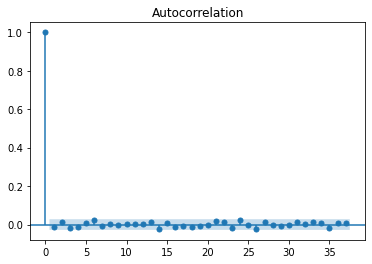

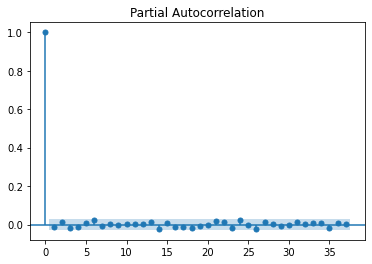

In [9]:
acf_plot = plot_acf(df_stationary.eur_usd_close_diff)
pacf_plot = plot_pacf(df_stationary.eur_usd_close_diff)